In [6]:
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from transformers import AutoModelForSequenceClassification
from transformers import Trainer
from datasets import load_metric

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np


In [2]:
df = pd.read_csv("clean.csv")
df.rename(columns={"text_clean": "text", "polarity": "label"}, inplace=True)
df.replace("", float("NaN"), inplace=True)
df.dropna(inplace=True)

df = df[['text', 'label']]
df.sample(5)

,text,label
804,bismillah moga rezeki laptop udah lambat bange...,positive
3651,masalah wfhkuliah onlen jadi kemarin pribadi n...,negative
3331,hari sakit asa cuti kerja sakit gin kuliah onl...,negative
3505,seperti gin rasa gedeg kuliah onlen mahal kuot...,negative
59,bismillah moga keikutsertaan bawa untung jawab...,positive


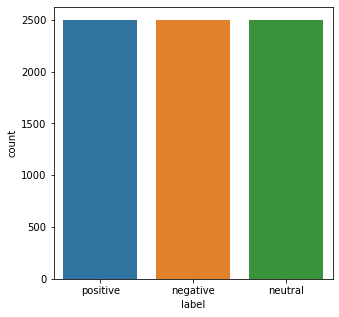

In [3]:
plt.figure(figsize=(5, 5))
sns.countplot(x=df['label'])
plt.show()

In [4]:
df["label"] = df["label"].map({"negative": 0, "neutral": 1, "positive": 2})

In [5]:
RANDOM_SEED = 42

df_train, df_test = train_test_split(
    df,
    test_size=0.2,
    random_state=RANDOM_SEED,
)

df_val, df_test = train_test_split(
    df_test,
    test_size=0.1,
    random_state=RANDOM_SEED,
)


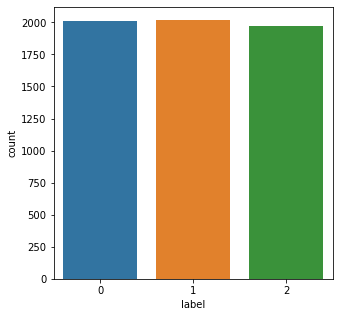

In [6]:
plt.figure(figsize=(5, 5))
sns.countplot(x=df_train['label'])
plt.show()

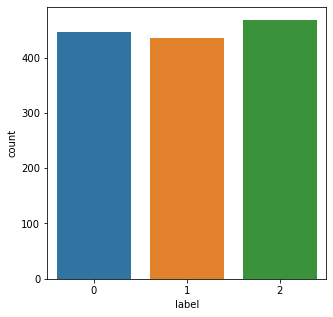

In [7]:
plt.figure(figsize=(5, 5))
sns.countplot(x=df_val['label'])
plt.show()

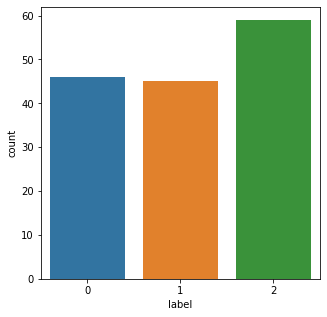

In [8]:
plt.figure(figsize=(5, 5))
sns.countplot(x=df_test['label'])
plt.show()

In [9]:
print(f'Total Train: {len(df_train)}')
print(f'Total Val  : {len(df_val)}')
print(f'Total Test : {len(df_test)}')

Total Train: 6000
Total Val  : 1350
Total Test : 150


In [10]:
actual_label = df_test['label']

In [11]:
df_train.to_csv("train.csv", index=False)
df_val.to_csv("eval.csv", index=False)
df_test.to_csv("test.csv", index=False)

In [12]:
from datasets import load_dataset

files = {
    "train": "train.csv", 
    "eval": "eval.csv", 
    "test": "test.csv",
}

dataset = load_dataset('csv', data_files=files)


Using custom data configuration default-2cca40a9748e6aaa


Extracting data files: 100%|██████████| 3/3 [00:00<00:00, 535.81it/s]


Dataset csv downloaded and prepared to C:\Users\ShinyQ\.cache\huggingface\datasets\csv\default-2cca40a9748e6aaa\0.0.0\433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519. Subsequent calls will reuse this data.


100%|██████████| 3/3 [00:00<00:00, 45.60it/s]


### **Tokenize Model**

In [11]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("indobenchmark/indobert-base-p2")

loading configuration file https://huggingface.co/indobenchmark/indobert-base-p2/resolve/main/config.json from cache at C:\Users\ShinyQ/.cache\huggingface\transformers\6dfdf4f043e25ac6a1e2816e3c5b23ced942aa5f62b783876ffcead141cf4712.866cfa4d1ce6c96629cf5f10be855daaeb37ddefaeb119903d6933f10d5e0d24
Model config BertConfig {
  "_name_or_path": "indobenchmark/indobert-base-p2",
  "_num_labels": 5,
  "architectures": [
    "BertModel"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "directionality": "bidi",
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3,
    "LABEL_4": 4
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attentio

In [14]:
def tokenize_function(text):
    return tokenizer(text["text"], padding='max_length', max_length=256)

tokenized_datasets = dataset.map(tokenize_function, batched=True)

100%|██████████| 1/1 [00:00<00:00, 32.97ba/s]


In [15]:
train_dataset = tokenized_datasets["train"]
eval_dataset = tokenized_datasets["eval"]

### **Train Model**

In [16]:
import torch
torch.cuda.empty_cache()

device = "cuda:0" if torch.cuda.is_available() else "cpu"
device

'cuda:0'

In [17]:
model = AutoModelForSequenceClassification.from_pretrained("indobenchmark/indobert-base-p2", num_labels=3)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [18]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    "test_trainer", 
    per_device_train_batch_size=4,
)

In [19]:
metric = load_metric("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)

    return metric.compute(predictions=predictions, references=labels)

torch.cuda.empty_cache()

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    compute_metrics=compute_metrics,
)

training_history = trainer.train()

The following columns in the training set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
e:\conda\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 6000
  Num Epochs = 3
  Instantaneous batch size per device = 4
  Total train batch size (w. parallel, distributed & accumulation) = 4
  Gradient Accumulation steps = 1
  Total optimization steps = 4500
 11%|█         | 500/4500 [04:23<35:29,  1.88it/s]Saving model checkpoint to test_trainer\checkpoint-500
Configuration saved in test_trainer\checkpoint-500\config.json


{'loss': 0.735, 'learning_rate': 4.4444444444444447e-05, 'epoch': 0.33}


Model weights saved in test_trainer\checkpoint-500\pytorch_model.bin
 22%|██▏       | 1000/4500 [08:52<29:48,  1.96it/s] Saving model checkpoint to test_trainer\checkpoint-1000
Configuration saved in test_trainer\checkpoint-1000\config.json


{'loss': 0.6667, 'learning_rate': 3.888888888888889e-05, 'epoch': 0.67}


Model weights saved in test_trainer\checkpoint-1000\pytorch_model.bin
 33%|███▎      | 1500/4500 [13:27<26:46,  1.87it/s]  Saving model checkpoint to test_trainer\checkpoint-1500


{'loss': 0.5891, 'learning_rate': 3.3333333333333335e-05, 'epoch': 1.0}


Configuration saved in test_trainer\checkpoint-1500\config.json
Model weights saved in test_trainer\checkpoint-1500\pytorch_model.bin
 44%|████▍     | 2000/4500 [18:05<22:25,  1.86it/s]  Saving model checkpoint to test_trainer\checkpoint-2000


{'loss': 0.3997, 'learning_rate': 2.777777777777778e-05, 'epoch': 1.33}


Configuration saved in test_trainer\checkpoint-2000\config.json
Model weights saved in test_trainer\checkpoint-2000\pytorch_model.bin
 56%|█████▌    | 2500/4500 [22:40<16:53,  1.97it/s]  Saving model checkpoint to test_trainer\checkpoint-2500


{'loss': 0.3695, 'learning_rate': 2.2222222222222223e-05, 'epoch': 1.67}


Configuration saved in test_trainer\checkpoint-2500\config.json
Model weights saved in test_trainer\checkpoint-2500\pytorch_model.bin
 67%|██████▋   | 3000/4500 [27:07<12:42,  1.97it/s]  Saving model checkpoint to test_trainer\checkpoint-3000


{'loss': 0.3825, 'learning_rate': 1.6666666666666667e-05, 'epoch': 2.0}


Configuration saved in test_trainer\checkpoint-3000\config.json
Model weights saved in test_trainer\checkpoint-3000\pytorch_model.bin
 78%|███████▊  | 3500/4500 [31:40<08:52,  1.88it/s]  Saving model checkpoint to test_trainer\checkpoint-3500


{'loss': 0.2309, 'learning_rate': 1.1111111111111112e-05, 'epoch': 2.33}


Configuration saved in test_trainer\checkpoint-3500\config.json
Model weights saved in test_trainer\checkpoint-3500\pytorch_model.bin
 89%|████████▉ | 4000/4500 [36:17<04:32,  1.83it/s]Saving model checkpoint to test_trainer\checkpoint-4000


{'loss': 0.2646, 'learning_rate': 5.555555555555556e-06, 'epoch': 2.67}


Configuration saved in test_trainer\checkpoint-4000\config.json
Model weights saved in test_trainer\checkpoint-4000\pytorch_model.bin
100%|██████████| 4500/4500 [40:55<00:00,  1.88it/s]Saving model checkpoint to test_trainer\checkpoint-4500
Configuration saved in test_trainer\checkpoint-4500\config.json


{'loss': 0.2129, 'learning_rate': 0.0, 'epoch': 3.0}


Model weights saved in test_trainer\checkpoint-4500\pytorch_model.bin


Training completed. Do not forget to share your model on huggingface.co/models =)


100%|██████████| 4500/4500 [41:05<00:00,  1.83it/s]


{'train_runtime': 2465.4691, 'train_samples_per_second': 7.301, 'train_steps_per_second': 1.825, 'train_loss': 0.4278603515625, 'epoch': 3.0}


### **Evaluate Model**

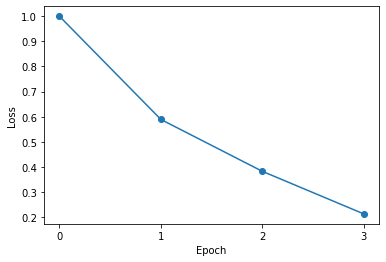

In [36]:
plt.plot([1, 0.5891, 0.3825, 0.2129], marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.xticks([0, 1, 2, 3])
plt.show()


In [22]:
evaluation_history = trainer.evaluate()
evaluation_history

The following columns in the evaluation set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1350
  Batch size = 8
100%|██████████| 169/169 [00:45<00:00,  3.71it/s]


{'eval_loss': 0.509102463722229,
 'eval_accuracy': 0.9059259259259259,
 'eval_runtime': 46.0643,
 'eval_samples_per_second': 29.307,
 'eval_steps_per_second': 3.669,
 'epoch': 3.0}

In [23]:
test_dataset = tokenized_datasets["test"]

prediction = trainer.predict(test_dataset)
prediction = prediction.predictions.argmax(1)

The following columns in the test set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 150
  Batch size = 8
100%|██████████| 19/19 [00:04<00:00,  3.88it/s]

In [42]:
print(classification_report(prediction, actual_label, target_names=["Negatif", "Netral", "Positif"]))

              precision    recall  f1-score   support

     Negatif       0.96      0.94      0.95        47
      Netral       0.80      0.88      0.84        41
     Positif       0.92      0.87      0.89        62

    accuracy                           0.89       150
   macro avg       0.89      0.90      0.89       150
weighted avg       0.90      0.89      0.89       150



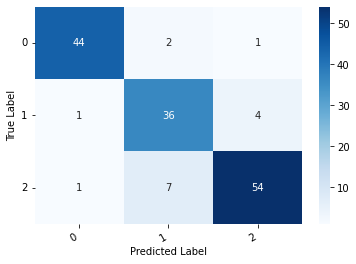

In [25]:
def show_confusion_matrix(confusion_matrix):
        hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
        hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
        hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')

        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')

cm = confusion_matrix(prediction, actual_label)
show_confusion_matrix(cm)

### **Save And Load Model**

In [26]:
model.save_pretrained("model")

Configuration saved in model\config.json
Model weights saved in model\pytorch_model.bin


In [7]:
model = AutoModelForSequenceClassification.from_pretrained("model")

In [8]:
trainer = Trainer(model=model)

In [13]:
def predict(text):
    tokenized = tokenizer(text, padding='max_length', max_length=256)
    label = trainer.predict([tokenized]).predictions.argmax(1)[0]
    if label == 0:
        print(f'Predicted: Negatif [{label}]')
    elif label == 1:
        print(f'Predicted: Netral [{label}]')
    else:
        print(f'Predicted: Positif [{label}]')


In [14]:
predict("""
    universitas telkom mahal banget bayar bpp full 
    padahal kuliah online gak dikembalikan duitnya
""")

***** Running Prediction *****
  Num examples = 1
  Batch size = 8
2it [02:29, 74.55s/it]               

Predicted: Negatif [0]


In [15]:
predict("saya senang sekali kuliah di universitas telkom")

***** Running Prediction *****
  Num examples = 1
  Batch size = 8
3it [02:37, 47.00s/it]

Predicted: Positif [2]


In [16]:
predict("kuliah online di tel-u enak-enak aja kok")

***** Running Prediction *****
  Num examples = 1
  Batch size = 8
4it [02:41, 30.80s/it]

Predicted: Netral [1]
